In [193]:
import Bio.bgzf as bgzf
import pysam
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.stats.api as sms
import seaborn as sns


from collections import defaultdict, Counter
from operator import itemgetter
from itertools import groupby

# Домашка 2. Выравнивание коротких ридов.
## Часть а. Анализ ридов Illumina

### Данные

Тестовый датасет: `test_1.fastq, test_2.fastq`<br>
Тестовый геном: `MG1655-K12.first10K.fasta`

Если ваша фамилия начинается на М-Я (моя фамилия на букву Ч):<br>
Датасет №1: `B.faecium/frag.R1.fastq.gz`, `B.faecium/frag.R2.fastq.gz`<br>
Датасет №2: `B.faecium/jump.R1.fastq.gz`, `B.faecium/jump.R2.fastq.gz`<br>
Референсный геном: `B.faecium/ref.fasta.gz*`<br>

Поехали!

#### 0. Разбораться с `Bowtie2` / `bwa mem`
Построить индекс, запустить любой из тулов на ваш выбор, определить процент приложившихся ридов (`samtools flagstat`). 

Выберу `bwa`.
<br>
Установим `bwa` and `samtools`
```
sudo apt-get install bwa
sudo apt-get install samtools
```
Далее, начнем работу с тестом:
индексируем, выравниваем, декобируем в бам и чекаем статистику:
```
$ bwa index MG1655-K12.first10K.fasta 
$ bwa mem MG1655-K12.first10K.fasta test_1.fastq test_2.fastq > alignment.sam
$ samtools view -S -b alignment.sam > alignment.bam
$ samtools flagstat alignment.bam
56320 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
56320 + 0 mapped (100.00% : N/A)
56320 + 0 paired in sequencing
28160 + 0 read1
28160 + 0 read2
56280 + 0 properly paired (99.93% : N/A)
56320 + 0 with itself and mate mapped
0 + 0 singletons (0.00% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)

```
т.е. замапилось 99.93 процента

Для нормальных датасетов аналогично:
```
bwa index ref.fasta
bwa mem ref.fasta jump.R1.fastq jump.R2.fastq > alignment_jump.sam
bwa mem ref.fasta frag.R1.fastq frag.R2.fastq > alignment_frag.sam
```


### 1. Покрытие генома.
По SAM файлу:
* построить график покрытия генома, 
* определить среднее покрытие и долю покрытой области генома. 

Покрытие одной позиции в геноме есть количество ридов, приложившихся так, что их концы находятся по разные стороны от этой позиции. График можно строить усредняя, например, по 1000 нуклеотидов. 

Доля покрытой области генома определяется как процент нуклеотидов с ненулевым покрытием по отношению ко всей длине генома.

##### Подсчет покрытия

Функция очень просто считает по строке cigar покрытие и возвращает массив "покрытие на каждый нуклеотид".

In [316]:
def count_cov(bamfile, length):
    base_cov = np.array([0 for i in range(length+1)])
    count = 0
    ex_counter = 0
    for read in bamfile:
        try:
            count += 1
            if count % 100000 == 0:
                print(count, end = ' ')
            if not read.is_unmapped:
                start = read.reference_start
                for tup in read.cigar:
                    s = start
                    f = start + tup[1]
                    if tup[0] == 8 or tup[0] == 7 or tup[0] == 1 or tup[0] == 0:  
                        for i in range(s, f):
                            base_cov[i] += 1
                    start = f
        except:
            ex_counter += 1
    print('\nРиды, при чтении которых возникла ошибка: '+str(ex_counter))
    return base_cov

##### Подсчет длины референсного генома.

Берем из информационной строки sam-файла

In [70]:
def read_len(sam):
    samfile = open(sam, 'r')
    line_0 = samfile.readline()
    samfile.close()
    ln = int(line_0.split('\t')[2].replace('LN:',''))
    return ln

##### График покрытия генома

In [71]:
def draw_coverage(cov):
    length = len(cov)//1000 + 1
    new_cov = np.array([])
    positions = np.array([])
    for i in range(length):
        positions = np.append(positions, i*1000)
        if i!=length-1:
            new_cov = np.append(new_cov, np.average(cov[i*1000:(i+1)*1000]))
        else:
            new_cov = np.append(new_cov, np.average(cov[i*1000:len(cov)]))
    plt.plot(positions, new_cov, linestyle="-", color = 'red')

##### Среднее покрытие и доля покрытой области генома.

In [72]:
def cov_stat(cov):
    avg = np.average(cov)
    zero_amount = np.count_nonzero(a == 0)
    part_of_cov = 1 - zero_amount/len(cov)
    return avg, part_of_cov

##### Запустим на тесте!

In [317]:
# Прочитаем файл, 

bam_test = 'data/test/alignment.bam'
bamfile_test = pysam.AlignmentFile(bam_test, 'rb')
sam_test = 'data/test/alignment.sam'
length_test = bamfile_test.lengths[0]

In [318]:
# Посчитаем покрытие и статистики
coverage_test = np.array(count_cov(bamfile_test, length_test))
average_cov_test, part_of_cov_test = cov_stat(coverage_test)


Риды, при чтении которых возникла ошибка: 0


In [319]:
# Выведем
print('Среднее покрытие:'+str(average_cov_test))
print('Доля покрытия:'+str(part_of_cov_test))

Среднее покрытие:508.92380761923806
Доля покрытия:1.0


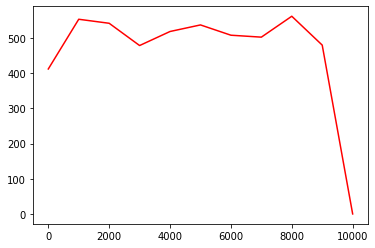

In [320]:
#Нарисуем график покрытия
draw_coverage(coverage_test)

##### Запустим на реальных данных!

In [306]:
# Прочитаем файл
bam = 'data/B.faecium/alignment_frag.bam'
bamfile = pysam.AlignmentFile(bam, 'rb')
sam = 'data/B.faecium/alignment_frag.sam'
length = bamfile.lengths[0]

In [307]:
# Посчитаем покрытие и статистики
coverage = np.array(count_cov(bamfile, length))
average_cov, part_of_cov = cov_stat(coverage)

100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 1400000 1500000 1600000 1700000 1800000 1900000 2000000 2100000 2200000 2300000 2400000 2500000 2600000 2700000 2800000 2900000 3000000 3100000 3200000 3300000 3400000 Риды, при чтении которых возникла ошибка: 23


### !!!Странно, иногда возникают ошибки (выход за пределы длины), я их ловлю). Их вроже немного, поэтому ок.

In [308]:
# Выведем
print('Среднее покрытие:'+str(average_cov))
print('Доля покрытия:'+str(part_of_cov))

Среднее покрытие:130.59156894399766
Доля покрытия:1.0


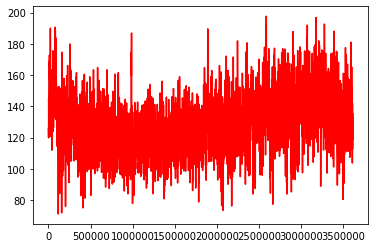

In [309]:
#Нарисуем график покрытия
draw_coverage(coverage)

### 2. Распределение расстояния вставки.
По SAM файлу:
* построить график распределения расстояния вставки, 
* определить среднее расстояние вставки, среднеквадратичное отклонение и интервал минимальной ширины, в который попадает 95% ридов. 

На графике по оси Х должно быть расстояние вставки, по оси Y — количество ридов в заданным расстоянием вставки.


##### Функция, возвращающая массив длин вставок

In [310]:
def insertion(bam_file):
    ins = np.array([])
    count = 0
    for read in bam_file:
        count += 1
        if count % 10000 == 0:
            print(count, end = ' ')
        if not read.is_unmapped:
            if read.template_length>0:
                 ins = np.append(ins, read.template_length)
    return(ins)

#### Посчитаем всякие нужные статистики

In [188]:
def count_stat(row):
    mean = np.mean(row)
    standart_d = np.std(row)
    interval = sms.DescrStatsW(row).tconfint_mean()
    return mean, standart_d, interval

##### Запустим на тесте

In [206]:
# Прочитаем файл, 
bam_test = 'data/test/alignment.bam'
bamfile_test = pysam.AlignmentFile(bam_test, 'rb')
sam_test = 'data/test/alignment.sam'
length_test = bamfile_test.lengths[0]

Посчитаем и выведем все, что нужно

In [207]:
insert_test = insertion(bamfile_test)

In [208]:
mean_test, standart_d_test, interval_test = count_stat(insert_test)
# Выведем
print('Cреднее расстояние вставки: '+str(mean_test))
print('Cреднеквадратичное отклонение: '+str(standart_d_test))
print('Интервал минимальной ширины, в который попадает 95% ридов: '+str(interval_test))

Cреднее расстояние вставки: 215.2860440340909
Cреднеквадратичное отклонение: 10.590040942453138
Интервал минимальной ширины, в который попадает 95% ридов: (215.16234799760394, 215.40974007057787)


График распределения расстояния вставки:


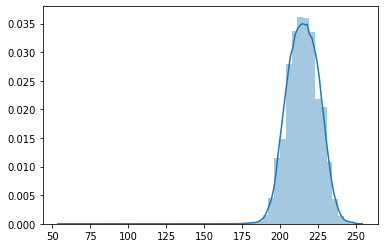

In [209]:
print('График распределения расстояния вставки:')
sns.distplot(insert_test)

##### Запустим на данных

In [214]:
# Прочитаем файл
bam = 'data/B.faecium/alignment_frag.bam'
bamfile = pysam.AlignmentFile(bam, 'rb')
sam = 'data/B.faecium/alignment_frag.sam'
length = bamfile.lengths[0]

In [215]:
insert = insertion(bamfile)

10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 240000 250000 260000 270000 280000 290000 300000 310000 320000 330000 340000 350000 360000 370000 380000 390000 400000 410000 420000 430000 440000 450000 460000 470000 480000 490000 500000 510000 520000 530000 540000 550000 560000 570000 580000 590000 600000 610000 620000 630000 640000 650000 660000 670000 680000 690000 700000 710000 720000 730000 740000 750000 760000 770000 780000 790000 800000 810000 820000 830000 840000 850000 860000 870000 880000 890000 900000 910000 920000 930000 940000 950000 960000 970000 980000 990000 1000000 1010000 1020000 1030000 1040000 1050000 1060000 1070000 1080000 1090000 1100000 1110000 1120000 1130000 1140000 1150000 1160000 1170000 1180000 1190000 1200000 1210000 1220000 1230000 1240000 1250000 1260000 1270000 1280000 1290000 1300000 1310000 1320000 1330000 1340000 1350000 1360000 1370000 1380000 1390

In [216]:
mean, standart_d, interval = count_stat(insert)
# Выведем
print('Cреднее расстояние вставки: '+str(mean))
print('Cреднеквадратичное отклонение: '+str(standart_d))
print('Интервал минимальной ширины, в который попадает 95% ридов: '+str(interval))

Cреднее расстояние вставки: 2372.5621806589907
Cреднеквадратичное отклонение: 63457.558974676875
Интервал минимальной ширины, в который попадает 95% ридов: (2277.40600499292, 2467.7183563250614)


График распределения расстояния вставки:


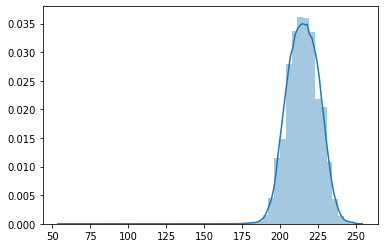

In [217]:
print('График распределения расстояния вставки:')
sns.distplot(insert_test)

УРА!

### 3. Частоты различных замен
Построить матрицу частот замен (A,C,G,T).
Так, в ячейке (А,С) должно стоять количество ошибок замены С на А (С в референсе, А в риде). Определить средний процент ошибок в ридах.
Я понимаю, как это делать, допишу потом.)))

## Часть b. Анализ ридов IonTorrent
### Данные: 
Тестовые данные: `test.fastq`, `test_reference.fasta`

Данные: `B22-730.fastq.gz`, `C24-698.fastq.gz`

Референсный геном: `DH10B-K12.fasta`

Обработаем (тестовый не заработал ваще):
```
$ bwa index DH10B-K12.fasta 
$ bwa mem DH10B-K12.fasta B22-730.fastq >alignment_B.sam
$ samtools view -S -b alignment_B.sam > alignment_B.bam
$ bwa mem DH10B-K12.fasta C24-698.fastq >alignment_C.sam
$ samtools view -S -b alignment_C.sam > alignment_C.bam

```

### 1. Статистика ридов IonTorrent
С помощью посчитать следующие статистики для ридов:
* Покрытие генома (график, процент покрытого генома, среднее покрытие)
* Средний процент ошибок в ридах
* Статистика длин инделов
* Статистика длин инделов в завимости от длины гомополимерного участка (участок состоящий из одного типа нуклеотидов, например АААААААА). Мы фиксируем длину гомополимерного участка (пусть 5bp), и находим все гомополимеры такой длины в референсе. Дальше смотрим как участки этой длины прочитались секвенатором. Смотрим сколько раз прочиталось 3bp, 4bp, 5bp, 6bp и итд. Повторяем это для гомополимеров всех длин (например, от 3 до 20).
* Статистика качества нуклеотидов
    * при ошибочно вставленном нуклеотиде
    * при замене
* Таблица частот замен/вставок/удалений


In [311]:
def read_al(path):
    bamfile = pysam.AlignmentFile(path+'.bam', 'rb')
    length = bamfile.lengths[0]
    return bamfile, length

In [321]:
def calculate_cov(bamfile, length):
    # покрытие:
    coverage = np.array(count_cov(bamfile, length))
    average_cov, part_of_cov = cov_stat(coverage)
    print('Среднее покрытие:'+str(average_cov))
    print('Доля покрытия:'+str(part_of_cov))
    draw_coverage(coverage)
    # ошибки в ридах
    

In [ ]:
def avg_error(bamfile, read):

In [322]:
# Прочитаем файл, 
bamfile, length = read_al('data/2b/alignment_B')

100000 200000 300000 400000 
Риды, при чтении которых возникла ошибка: 7
Среднее покрытие:34.06491358129018
Доля покрытия:1.0


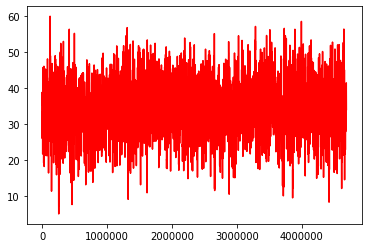

In [323]:
calculate_cov(bamfile, length)